In [ ]:
!pip install kaggle
!echo '{"username":"gr4ceg","key":"08da1952aa6a96f237cf1e4c73f05c26"}' > kaggle.json
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c cs-480-2024-spring
!unzip -q *.zip

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from graphviz import Digraph

import torch
from torchvision import transforms
from PIL import Image

# Example function to extract features from images using a pre-trained EfficientNet model
from torchvision.models import efficientnet_b7

import numpy as np
from tqdm import tqdm  # Import tqdm for the progress bar

from torch.utils.data import DataLoader, Dataset

from catboost import CatBoostRegressor, Pool

In [25]:
# Load the data
train_data = pd.read_csv('/kaggle/working/data/train.csv')

ancillary_columns = train_data.columns[1:164]
print(ancillary_columns)

label_columns = train_data.columns[164:]
print(label_columns)

Index(['WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO12_annual_precipitation',
       'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
       'WORLDCLIM_BIO15_precipitation_seasonality',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'WORLDCLIM_BIO7_temperature_annual_range',
       'SOIL_bdod_0.5cm_mean_0.01_deg', 'SOIL_bdod_100.200cm_mean_0.01_deg',
       'SOIL_bdod_15.30cm_mean_0.01_deg', 'SOIL_bdod_30.60cm_mean_0.01_deg',
       ...
       'VOD_X_1997_2018_multiyear_mean_m03',
       'VOD_X_1997_2018_multiyear_mean_m04',
       'VOD_X_1997_2018_multiyear_mean_m05',
       'VOD_X_1997_2018_multiyear_mean_m06',
       'VOD_X_1997_2018_multiyear_mean_m07',
       'VOD_X_1997_2018_multiyear_mean_m08',
       'VOD_X_1997_2018_multiyear_mean_m09',
       'VOD_X_1997_2018_multiyear_mean_m10',
       'VOD_X_1997_2018_multiyear_mean_m11',
       'VOD_X_1997_2018_multiyear_mean_m12'],
      dtype='object', length=163)
Index(['X4_mean', 'X11_

In [26]:
# Split features and targets
image_paths = 'data/train_images/' + train_data.iloc[:, 0].astype(str) + '.jpeg'

ancillary_data = train_data.iloc[:, 1:164]
labels = train_data.iloc[:, 164:]

# Split the data into training and validation sets
train_ancillary, val_ancillary, train_labels, val_labels, train_images, val_images = train_test_split(
    ancillary_data, labels, image_paths, test_size=0.20, random_state=42)

In [27]:
train_images = train_images.to_numpy()
val_images = val_images.to_numpy()

In [28]:
print(f"Training ancillary data: {train_ancillary.shape}")
print(f"Validation ancillary data: {val_ancillary.shape}")
print(f"Training labels: {train_labels.shape}")
print(f"Validation labels: {val_labels.shape}")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

Training ancillary data: (34690, 163)
Validation ancillary data: (8673, 163)
Training labels: (34690, 6)
Validation labels: (8673, 6)
Training images: 34690
Validation images: 8673


In [29]:
print(image_paths.head())
print(ancillary_data[:5])
print(labels[:5])

0    data/train_images/101801795.jpeg
1    data/train_images/115813315.jpeg
2    data/train_images/173551949.jpeg
3    data/train_images/148811120.jpeg
4    data/train_images/195108876.jpeg
Name: id, dtype: object
   WORLDCLIM_BIO1_annual_mean_temperature  \
0                               21.478968   
1                               26.927639   
2                               27.336945   
3                               25.558649   
4                               25.204723   

   WORLDCLIM_BIO12_annual_precipitation  \
0                            772.404785   
1                           1456.733276   
2                            992.366638   
3                           2246.017822   
4                           2309.776123   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                         110.047623                       
1                                         329.366669                       
2                           

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

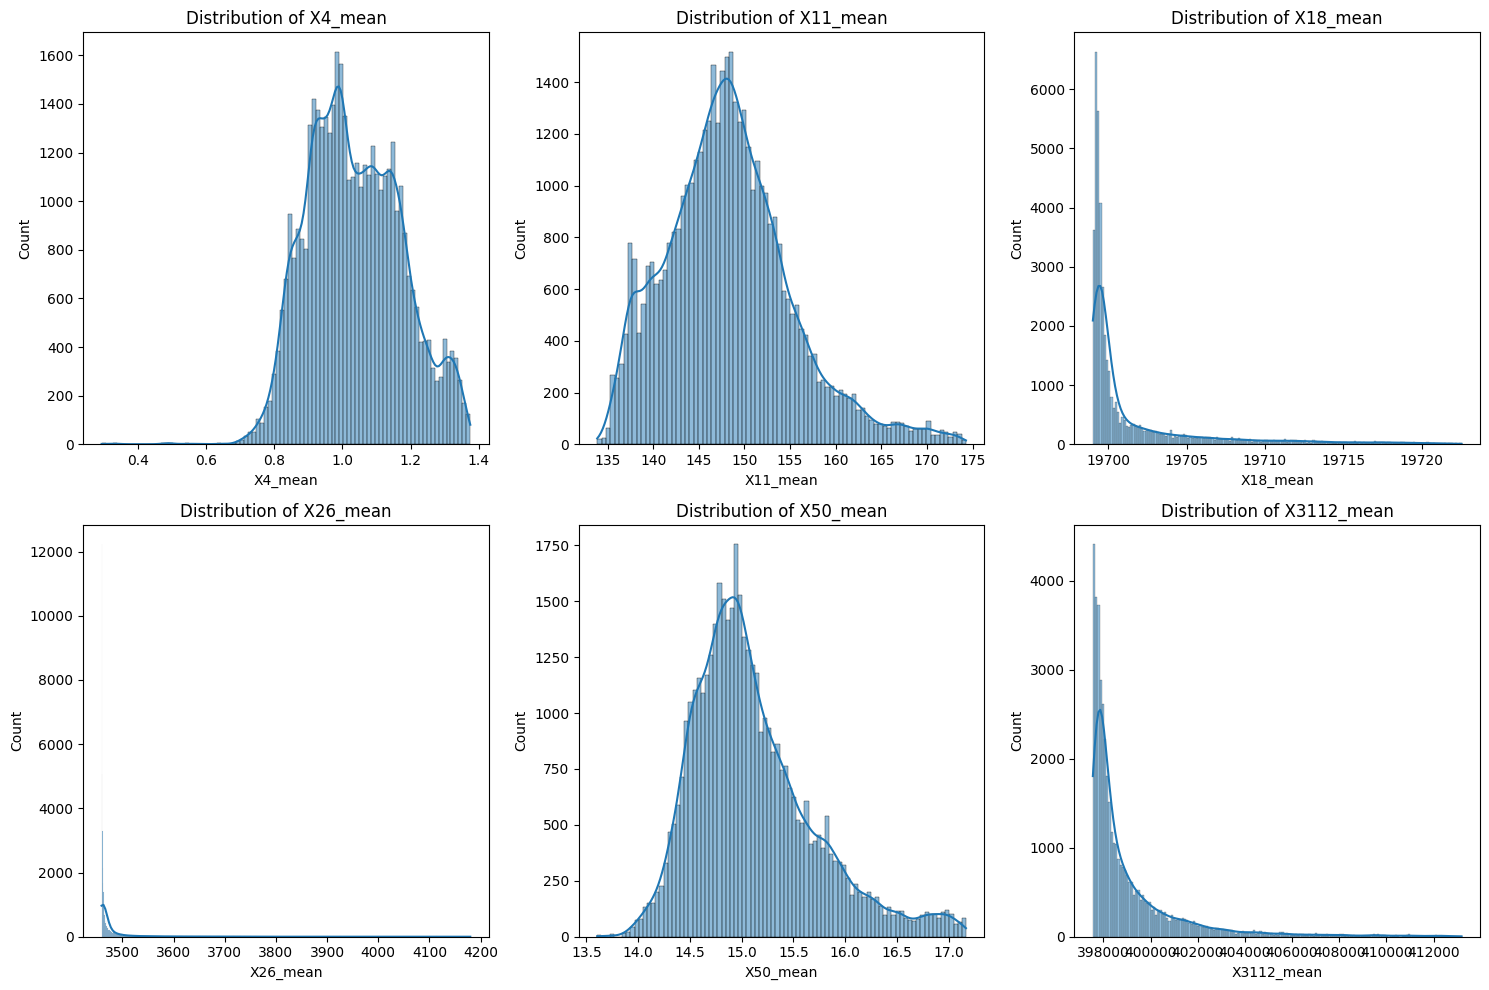

In [30]:
# Plot histograms for each trait
traits = labels.columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, trait in enumerate(traits):
    sns.histplot(labels[trait], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {trait}')
    axes[i].set_xlabel(trait)

plt.tight_layout()
plt.show()

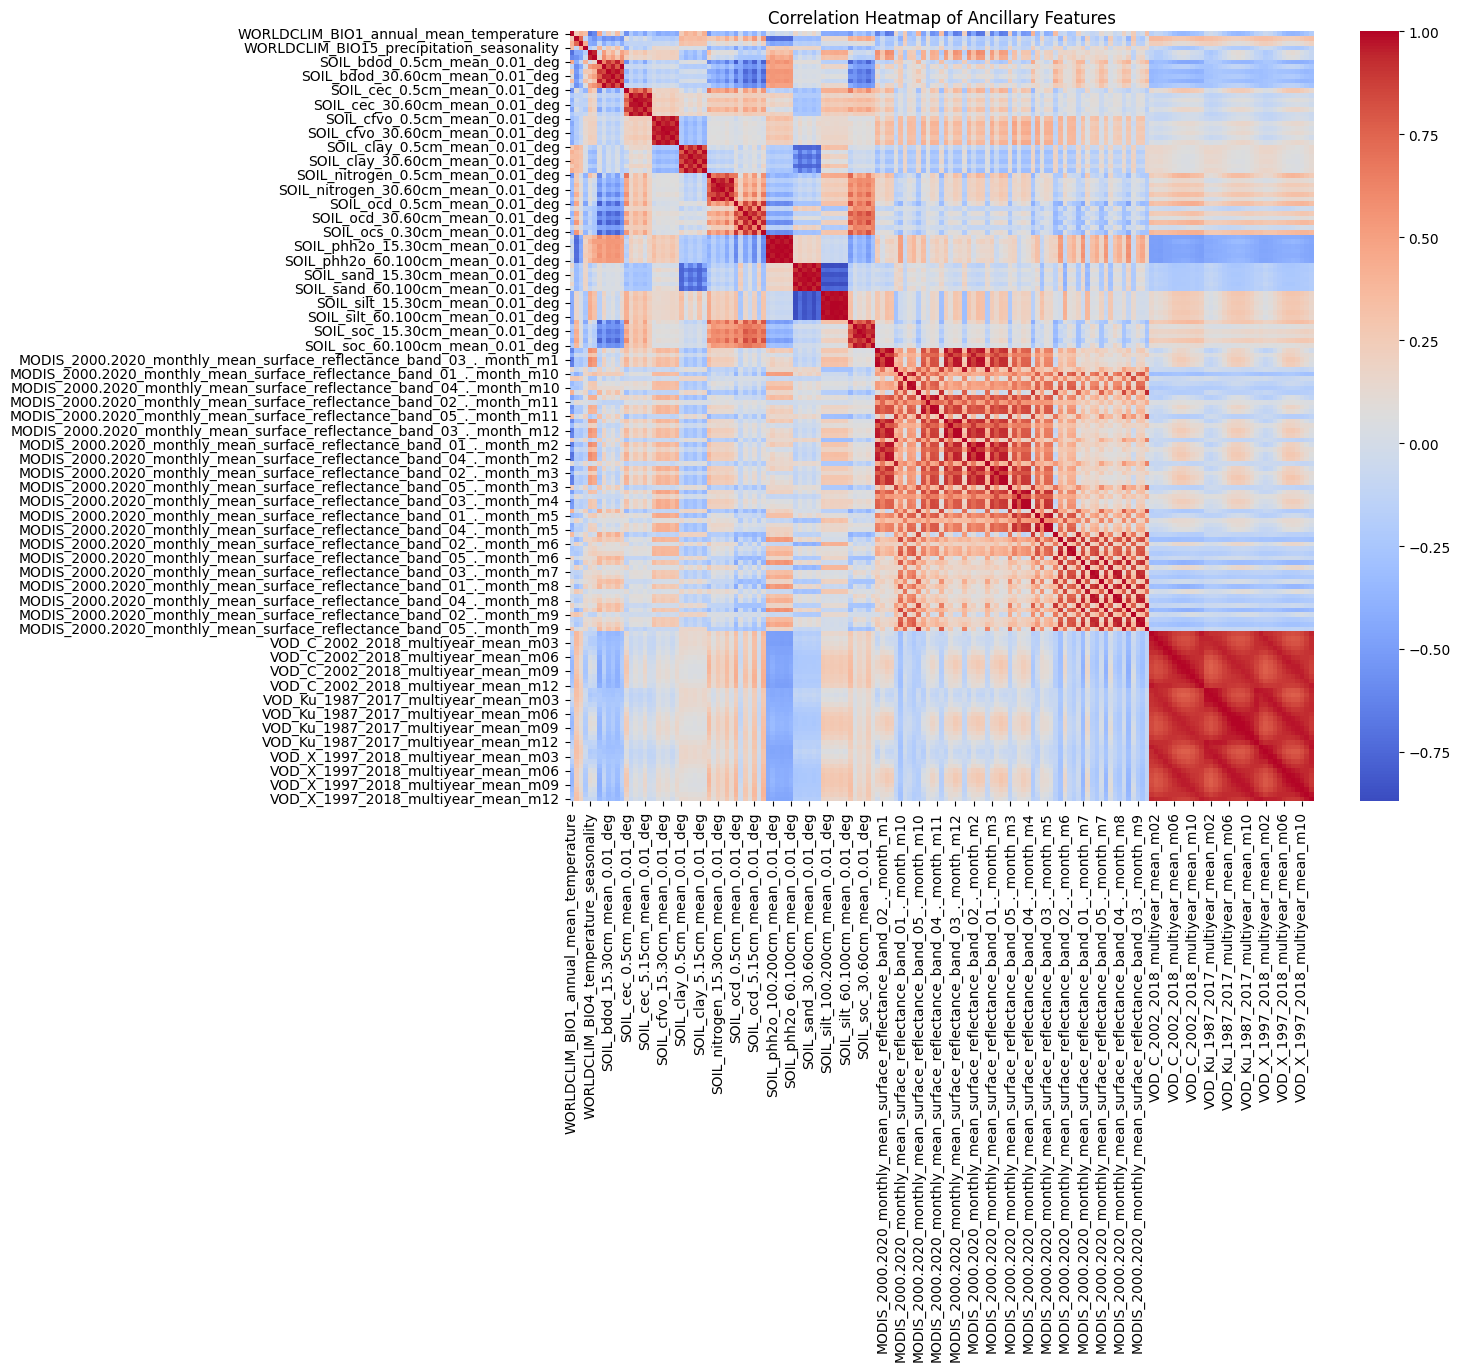

In [32]:
corr = pd.DataFrame(ancillary_data, columns=ancillary_data.columns).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Heatmap of Ancillary Features')
plt.show()

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [35]:
# Define the augmentation pipeline
augmentation_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1
    ),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Example function to load and preprocess an image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = augmentation_pipeline(image)
    return image

In [36]:
# Load pre-trained EfficientNet B7 model and move it to GPU
effnet_model = efficientnet_b7(pretrained=True)

# try using the last layer withour rthe pooling
# effnet_model = torch.nn.Sequential(*list(effnet_model.children())[:-2], torch.nn.AdaptiveAvgPool2d((1, 1)))
effnet_model = torch.nn.Sequential(*list(effnet_model.children())[:-1])
effnet_model = effnet_model.to(device)  # Move the model to GPU

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
class ImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_and_preprocess_image(self.image_paths[idx])
        return image

def extract_features_dataloader(dataloader):
    features = []
    effnet_model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting Features with DataLoader"):
            batch = batch.to(device)
            batch_features = effnet_model(batch).flatten(start_dim=1)
            features.append(batch_features.cpu().numpy())
    return torch.tensor(np.concatenate(features, axis=0))

In [39]:
train_dataset = ImageDataset(train_images)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
train_image_features = extract_features_dataloader(train_dataloader)

val_dataset = ImageDataset(val_images)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
val_image_features = extract_features_dataloader(val_dataloader)

Extracting Features with DataLoader: 100%|██████████| 272/272 [00:36<00:00,  7.46it/s]


In [40]:
# Assuming train_ancillary, train_image_features, and train_labels are already defined
X_train_combined = np.concatenate([train_ancillary, train_image_features], axis=1)
X_val_combined = np.concatenate([val_ancillary, val_image_features], axis=1)

# Split data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_combined, train_labels, test_size=0.2, random_state=42)

# Dictionary to store models and their training logs
models = {}
training_logs = {}

# Train separate CatBoost models for each trait with GPU, early stopping, and multi-threading
for i, trait in tqdm(enumerate(labels.columns), total=len(labels.columns), desc="Training Models"):
    model = CatBoostRegressor(
        iterations=1500,  # Reduced iterations
        depth=6,
        learning_rate=0.01,
        loss_function='RMSE',
        task_type='GPU',  # Enable GPU training
        early_stopping_rounds=50,  # Enable early stopping
        thread_count=-1,  # Use all available CPU cores
        logging_level='Verbose'  # Enable detailed logging
    )
    
    # Create Pool for validation set
#     train_pool = Pool(X_train, y_train.iloc[:, i])
#     val_pool = Pool(X_val, y_val.iloc[:, i])
    train_pool = Pool(X_train_combined, train_labels.iloc[:, i])
    val_pool = Pool(X_val_combined, val_labels.iloc[:, i])
    
    # Fit the model
    model.fit(train_pool, eval_set=val_pool, verbose=100)  # Adjust verbose as needed

    # Store the model
    models[trait] = model

    # Store the training logs
    training_logs[trait] = model.get_evals_result()

Training Models:   0%|          | 0/6 [00:00<?, ?it/s]

0:	learn: 0.1354093	test: 0.1363595	best: 0.1363595 (0)	total: 196ms	remaining: 1m 38s
100:	learn: 0.1192786	test: 0.1245619	best: 0.1245619 (100)	total: 17.1s	remaining: 1m 7s
200:	learn: 0.1157405	test: 0.1240025	best: 0.1239936 (196)	total: 33.6s	remaining: 50s
300:	learn: 0.1130283	test: 0.1237929	best: 0.1237822 (289)	total: 49.9s	remaining: 33s
400:	learn: 0.1105264	test: 0.1235668	best: 0.1235629 (391)	total: 1m 6s	remaining: 16.3s


Training Models:  17%|█▋        | 1/6 [02:18<11:32, 138.46s/it]

bestTest = 0.1235537855
bestIteration = 422
Shrink model to first 423 iterations.
0:	learn: 6.8177805	test: 6.8487698	best: 6.8487698 (0)	total: 192ms	remaining: 1m 35s
100:	learn: 5.9518941	test: 6.1586484	best: 6.1586484 (100)	total: 17.3s	remaining: 1m 8s
200:	learn: 5.7667053	test: 6.1218630	best: 6.1209289 (186)	total: 33.8s	remaining: 50.2s
300:	learn: 5.6192197	test: 6.1120231	best: 6.1114636 (297)	total: 50s	remaining: 33s
400:	learn: 5.4946043	test: 6.1010751	best: 6.1006634 (396)	total: 1m 6s	remaining: 16.4s


Training Models:  33%|███▎      | 2/6 [04:41<09:23, 140.93s/it]

499:	learn: 5.3790732	test: 6.0990993	best: 6.0990012 (469)	total: 1m 22s	remaining: 0us
bestTest = 6.099001212
bestIteration = 469
Shrink model to first 470 iterations.
0:	learn: 4.2361140	test: 4.1653473	best: 4.1653473 (0)	total: 190ms	remaining: 1m 34s
100:	learn: 3.4171780	test: 3.5313476	best: 3.5312467 (99)	total: 17.2s	remaining: 1m 8s
200:	learn: 3.2507308	test: 3.4951665	best: 3.4945768 (198)	total: 33.9s	remaining: 50.4s
300:	learn: 3.1218003	test: 3.4793856	best: 3.4793856 (300)	total: 50.5s	remaining: 33.4s
400:	learn: 3.0183929	test: 3.4706636	best: 3.4701170 (397)	total: 1m 6s	remaining: 16.5s


Training Models:  50%|█████     | 3/6 [07:04<07:05, 141.88s/it]

499:	learn: 2.9296509	test: 3.4600132	best: 3.4592396 (491)	total: 1m 23s	remaining: 0us
bestTest = 3.459239599
bestIteration = 491
Shrink model to first 492 iterations.
0:	learn: 66.5686051	test: 65.6228335	best: 65.6228335 (0)	total: 188ms	remaining: 1m 33s
100:	learn: 57.5328610	test: 60.7129991	best: 60.7103042 (99)	total: 16.5s	remaining: 1m 5s
200:	learn: 54.3771207	test: 60.5818058	best: 60.5696373 (177)	total: 32.5s	remaining: 48.4s


Training Models:  67%|██████▋   | 4/6 [08:50<04:15, 127.77s/it]

bestTest = 60.55797283
bestIteration = 230
Shrink model to first 231 iterations.
0:	learn: 0.5862126	test: 0.5986697	best: 0.5986697 (0)	total: 184ms	remaining: 1m 31s
100:	learn: 0.5368632	test: 0.5609677	best: 0.5609508 (98)	total: 16.8s	remaining: 1m 6s
200:	learn: 0.5218998	test: 0.5592453	best: 0.5591970 (196)	total: 33s	remaining: 49.1s
300:	learn: 0.5101483	test: 0.5586159	best: 0.5586056 (293)	total: 49s	remaining: 32.4s


Training Models:  83%|████████▎ | 5/6 [10:54<02:06, 126.45s/it]

bestTest = 0.5582148875
bestIteration = 343
Shrink model to first 344 iterations.
0:	learn: 2226.2822959	test: 2147.4082267	best: 2147.4082267 (0)	total: 192ms	remaining: 1m 35s
100:	learn: 1868.7134514	test: 1876.4891869	best: 1876.0687123 (92)	total: 17s	remaining: 1m 7s
200:	learn: 1792.5095186	test: 1871.5937754	best: 1871.5937754 (200)	total: 33.2s	remaining: 49.4s


Training Models: 100%|██████████| 6/6 [12:39<00:00, 126.54s/it]

bestTest = 1870.342654
bestIteration = 217
Shrink model to first 218 iterations.


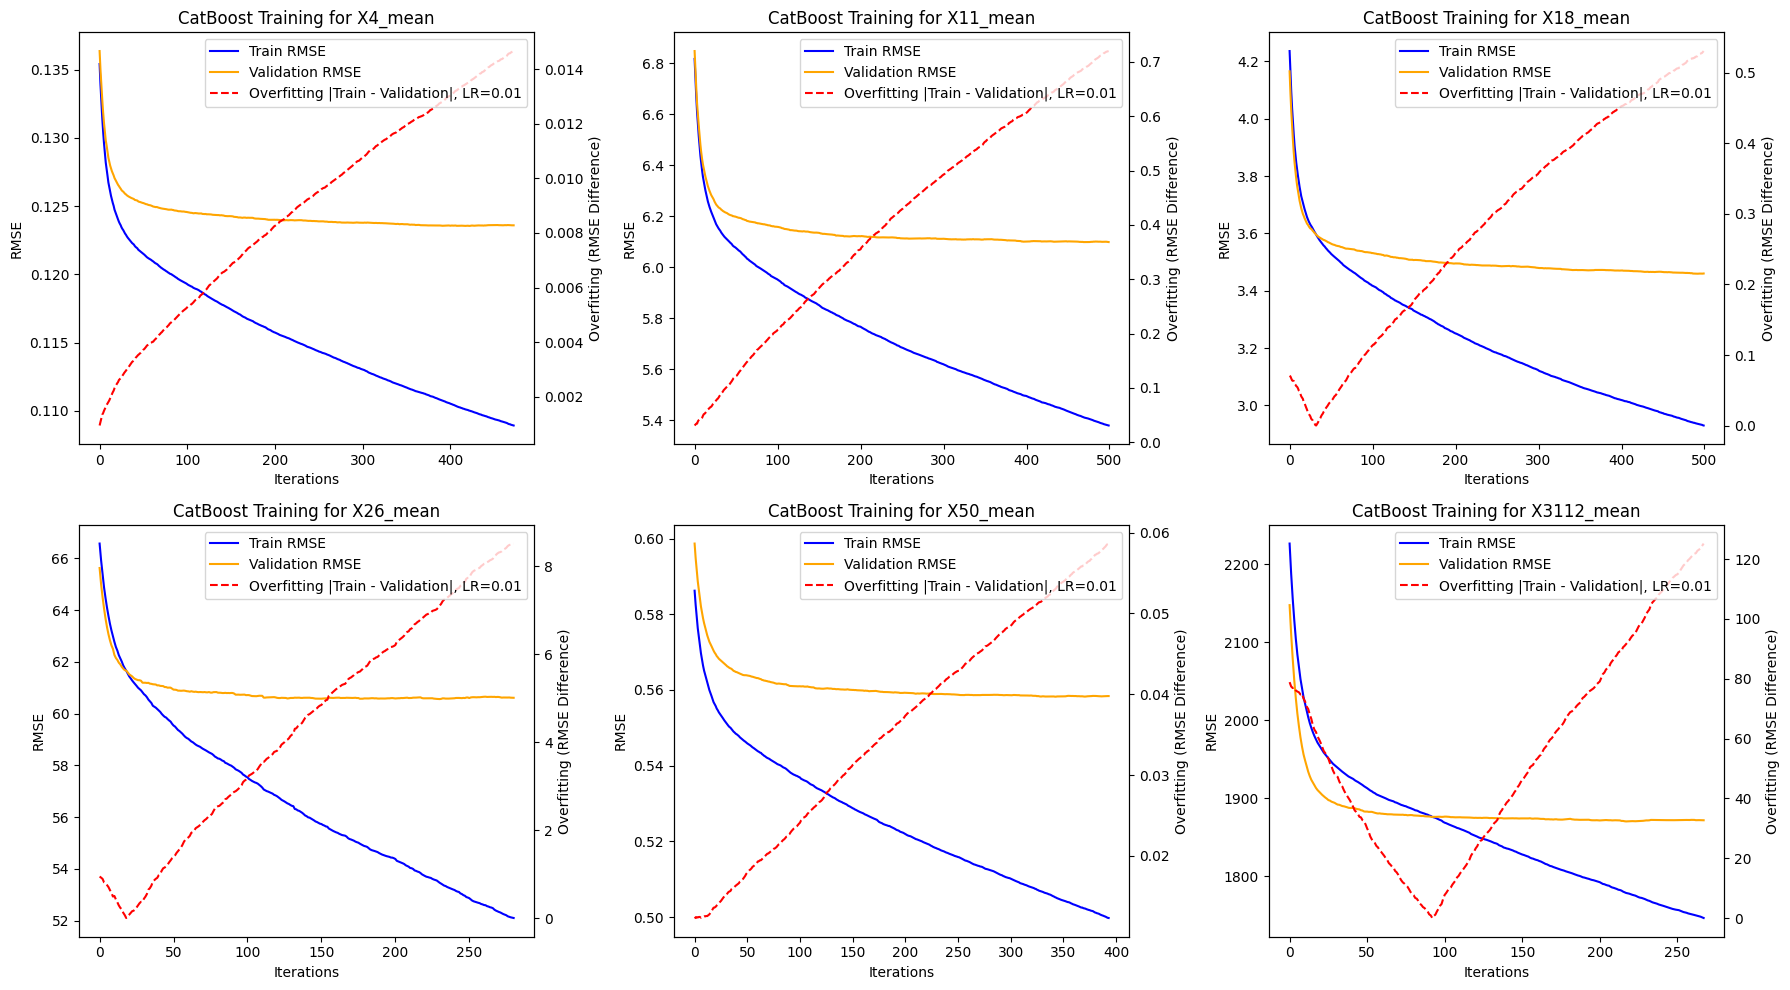

In [41]:
# Plotting the training logs
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Create a subplot for each trait
for i, (trait, logs) in enumerate(training_logs.items()):
    ax = axes[i]
    
    # Plot Train and Validation RMSE on the primary y-axis
    ax.plot(logs['learn']['RMSE'], label='Train RMSE', color='blue')
    ax.plot(logs['validation']['RMSE'], label='Validation RMSE', color='orange')
    
    ax.set_title(f'CatBoost Training for {trait}')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('RMSE')
    
    # Create a secondary y-axis to plot overfitting
    ax2 = ax.twinx()
    overfitting = np.abs(np.array(logs['learn']['RMSE']) - np.array(logs['validation']['RMSE']))
    ax2.plot(overfitting, label='Overfitting |Train - Validation|, LR=0.01', color='red', linestyle='--')
    ax2.set_ylabel('Overfitting (RMSE Difference)')
    
    # Combine legends from both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')


plt.tight_layout()
plt.savefig('catboost.png')
plt.show()



In [42]:
from sklearn.metrics import r2_score

# X_val_combined = np.concatenate([val_ancillary, val_image_features], axis=1)

r2_scores = {}
for i, trait in tqdm(enumerate(val_labels.columns), total=len(val_labels.columns), desc="Validating Models"):
    y_pred = models[trait].predict(X_val_combined)  # Predictions use GPU if CatBoost model was trained on GPU
    r2_scores[trait] = r2_score(val_labels.iloc[:, i], y_pred)

print("R2 Scores:", r2_scores)

Validating Models: 100%|██████████| 6/6 [01:06<00:00, 11.09s/it]

R2 Scores: {'X4_mean': 0.19832829477615432, 'X11_mean': 0.22748958041541878, 'X18_mean': 0.33745145918588115, 'X26_mean': 0.16567799246852422, 'X50_mean': 0.14372727078548053, 'X3112_mean': 0.2705651508411936}


In [43]:
# Load the data
test_data = pd.read_csv('/kaggle/working/data/test.csv')

ancillary_columns = test_data.columns[1:164]
print(ancillary_columns)

Index(['WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO12_annual_precipitation',
       'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
       'WORLDCLIM_BIO15_precipitation_seasonality',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'WORLDCLIM_BIO7_temperature_annual_range',
       'SOIL_bdod_0.5cm_mean_0.01_deg', 'SOIL_bdod_100.200cm_mean_0.01_deg',
       'SOIL_bdod_15.30cm_mean_0.01_deg', 'SOIL_bdod_30.60cm_mean_0.01_deg',
       ...
       'VOD_X_1997_2018_multiyear_mean_m03',
       'VOD_X_1997_2018_multiyear_mean_m04',
       'VOD_X_1997_2018_multiyear_mean_m05',
       'VOD_X_1997_2018_multiyear_mean_m06',
       'VOD_X_1997_2018_multiyear_mean_m07',
       'VOD_X_1997_2018_multiyear_mean_m08',
       'VOD_X_1997_2018_multiyear_mean_m09',
       'VOD_X_1997_2018_multiyear_mean_m10',
       'VOD_X_1997_2018_multiyear_mean_m11',
       'VOD_X_1997_2018_multiyear_mean_m12'],
      dtype='object', length=163)


In [44]:
# Split features and targets
test_image_paths = 'data/test_images/' + test_data.iloc[:, 0].astype(str) + '.jpeg'

test_ancillary_data = test_data.iloc[:, 1:164]
test_labels = test_data.iloc[:, 164:]

test_image_paths = test_image_paths.to_numpy()

In [ ]:
# Generate predictions for the test set
test_dataset = ImageDataset(test_image_paths)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_image_features = extract_features_dataloader(test_dataloader)  # Define test_image_paths

X_test_combined = np.concatenate([test_ancillary_data, test_image_features], axis=1)

test_ids = test_data['id'].values  # Extract test IDs from the test dataset

submission = pd.DataFrame({'id': test_ids})  # Define test_ids
for trait in models:
    submission[trait] = models[trait].predict(X_test_combined)

submission.to_csv('submission.csv', index=False)

Extracting Features with DataLoader: 100%|██████████| 200/200 [00:26<00:00,  7.46it/s]
